In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Nooni/2863.jpg
/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Nooni/187.jpg
/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Nooni/2844.jpg
/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Nooni/708.jpg
/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Nooni/2866.jpg
/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Nooni/185.jpg
/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Nooni/703.jpg
/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Nooni/2852.jpg
/kaggle/inpu

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5945 files belonging to 40 classes.


In [28]:
class_names = dataset.class_names
len(class_names)

40

In [7]:
len(dataset)

186

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[ 8  6 38 15  3  5  8 21 17 30 29 10 12 25 31 11 37  3 10  8 30  4  9 15
 11 12 23  1 10  4 13 29]


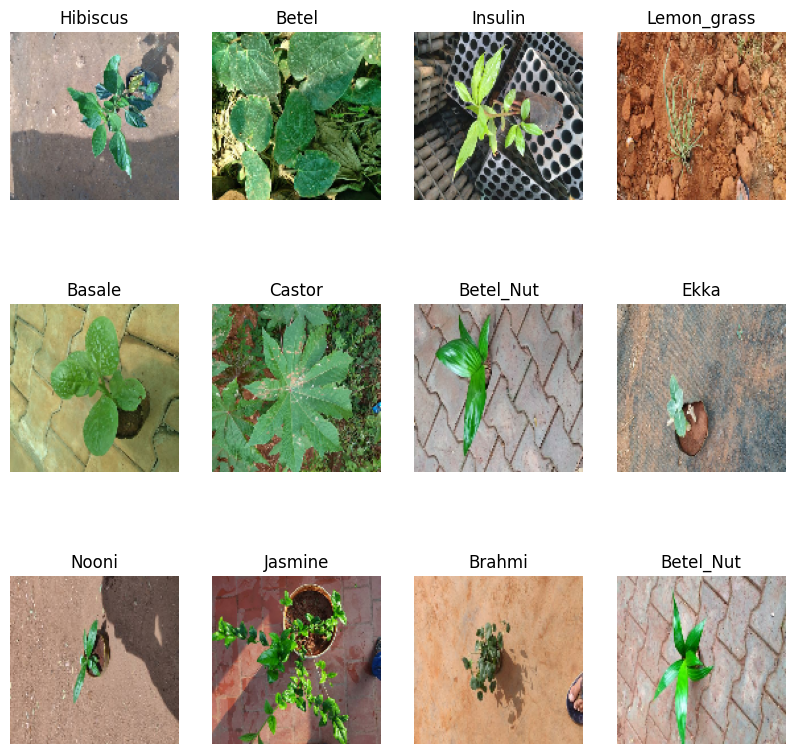

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
train_size = 0.8
len(dataset)*train_size

148.8

In [11]:
train_ds = dataset.take(172)
len(train_ds)

172

In [12]:
test_ds = dataset.skip(172)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

18.6

In [14]:
val_ds = test_ds.take(21)
len(val_ds)

14

In [15]:
test_ds = test_ds.skip(21)
len(test_ds)

0

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

148

In [19]:
len(val_ds)

18

In [20]:
len(test_ds)

20

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 40

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 63, 63, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 30, 30, 64)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 28, 28, 64)         

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=70,
)

Epoch 1/70
148/148 [==============================] - 77s 518ms/step - loss: 3.6378 - accuracy: 0.0321 - val_loss: 3.4595 - val_accuracy: 0.0538
Epoch 2/70
148/148 [==============================] - 67s 449ms/step - loss: 3.1836 - accuracy: 0.1032 - val_loss: 2.8956 - val_accuracy: 0.1545
Epoch 3/70
148/148 [==============================] - 66s 443ms/step - loss: 2.8613 - accuracy: 0.1683 - val_loss: 2.7007 - val_accuracy: 0.2257
Epoch 4/70
148/148 [==============================] - 64s 431ms/step - loss: 2.3630 - accuracy: 0.2931 - val_loss: 2.1733 - val_accuracy: 0.3750
Epoch 7/70
148/148 [==============================] - 63s 428ms/step - loss: 2.2313 - accuracy: 0.3223 - val_loss: 2.1064 - val_accuracy: 0.3628
Epoch 8/70
148/148 [==============================] - 62s 421ms/step - loss: 2.0732 - accuracy: 0.3703 - val_loss: 2.0817 - val_accuracy: 0.3750
Epoch 9/70
148/148 [==============================] - 62s 419ms/step - loss: 1.9880 - accuracy: 0.3954 - val_loss: 1.9899 - val_ac

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



148/148 [==============================] - 62s 416ms/step - loss: 0.5999 - accuracy: 0.7991 - val_loss: 0.6589 - val_accuracy: 0.7760
Epoch 47/70
148/148 [==============================] - 62s 419ms/step - loss: 0.5640 - accuracy: 0.8139 - val_loss: 1.1908 - val_accuracy: 0.6510
Epoch 48/70
148/148 [==============================] - 65s 436ms/step - loss: 0.5668 - accuracy: 0.8145 - val_loss: 0.6784 - val_accuracy: 0.7847
Epoch 49/70
148/148 [==============================] - 64s 435ms/step - loss: 0.5523 - accuracy: 0.8107 - val_loss: 0.5192 - val_accuracy: 0.8351
Epoch 50/70
148/148 [==============================] - 64s 429ms/step - loss: 0.5204 - accuracy: 0.8287 - val_loss: 0.5570 - val_accuracy: 0.8281
Epoch 51/70
148/148 [==============================] - 63s 428ms/step - loss: 0.5482 - accuracy: 0.8188 - val_loss: 0.5671 - val_accuracy: 0.7986
Epoch 52/70
148/148 [==============================] - 64s 434ms/step - loss: 0.5130 - accuracy: 0.8283 - val_loss: 0.5878 - val_accurac

In [34]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 8s 97ms/step - loss: 0.4108 - accuracy: 0.8625


In [35]:
scores

[0.41079068183898926, 0.862500011920929]

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 70, 'steps': 148}

In [38]:
history.history

{'loss': [3.6378071308135986,
  3.1835851669311523,
  2.861298084259033,
  2.6757922172546387,
  2.512716054916382,
  2.3630096912384033,
  2.2312655448913574,
  2.0731606483459473,
  1.9879772663116455,
  1.9126330614089966,
  1.8225992918014526,
  1.757020115852356,
  1.6717232465744019,
  1.6042187213897705,
  1.5301274061203003,
  1.426504135131836,
  1.4383881092071533,
  1.364600658416748,
  1.286921501159668,
  1.2581841945648193,
  1.216766357421875,
  1.1482481956481934,
  1.1294224262237549,
  1.061295747756958,
  1.0607179403305054,
  1.0139217376708984,
  0.9472561478614807,
  0.9575997591018677,
  0.9230074882507324,
  0.9066343307495117,
  0.8706422448158264,
  0.8285799026489258,
  0.7927885055541992,
  0.784973680973053,
  0.7660884261131287,
  0.7758426070213318,
  0.7761982083320618,
  0.7018519043922424,
  0.7290025949478149,
  0.6943172216415405,
  0.6547031998634338,
  0.6391889452934265,
  0.6341907382011414,
  0.6245628595352173,
  0.5863993167877197,
  0.5999386

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (50,) and (70,)

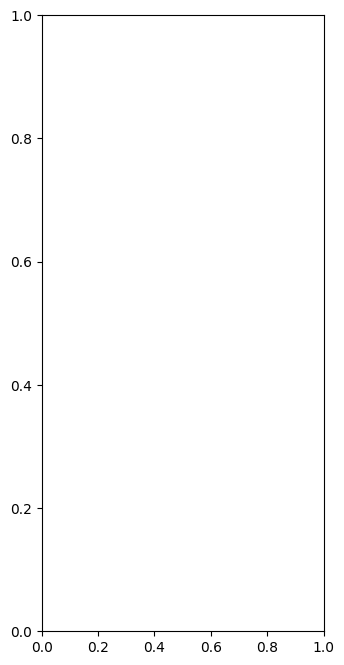

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Aloevera
1/1 [==============================] - 0s 242ms/step
predicted label: Aloevera


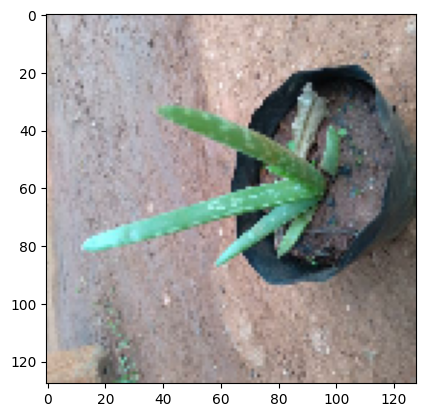

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 25ms/step


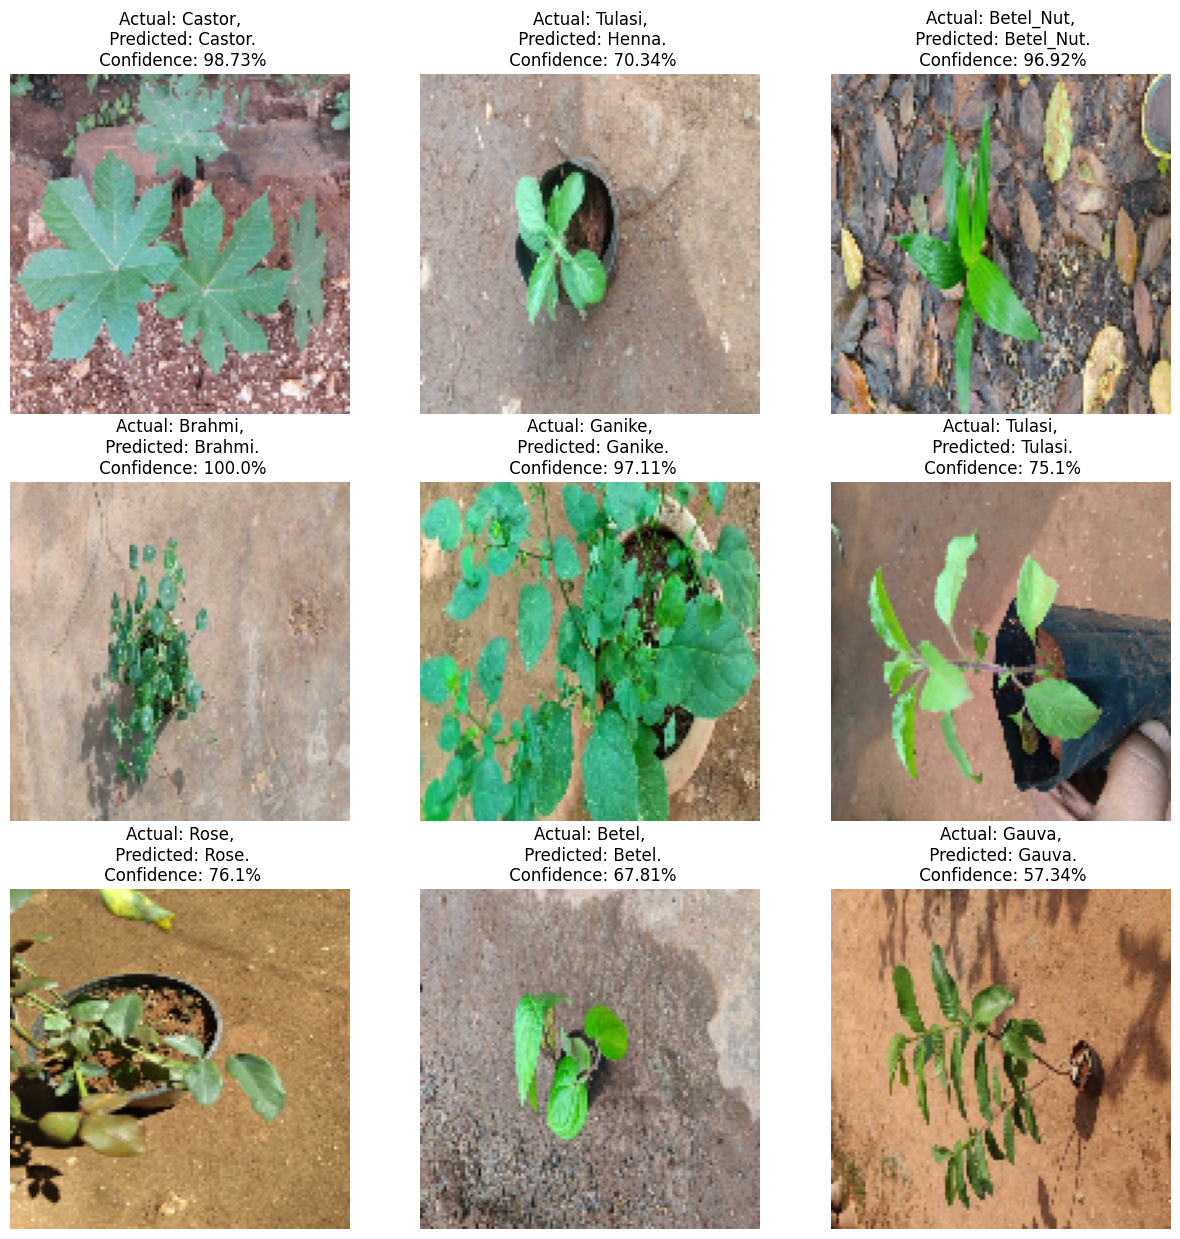

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
model.save(f"/Users/Aryan/Documents/Ayurvedic_Plants_detector_model")